## Get zonal statistics per reef

This notebook demonstrates how to extract and summarise zonal statistics from a raster (Zarr) dataset using the "Complete GBR Features" dataset. If the raster files contains more than one layer (time) the zonal statistics will be calculated for each layer.

The steps are:
1. Load the reef polygons dataset and use only reefs type  
2. Load the raster dataset
3. Clip to the GBR region, add CRS and set the variables that define lat/lot
4. Rasterise reef polygons using the raster file as a template
5. Calculate zonal statistics for each layer of the raster dataset

In addition to the standard python packages required for the DMS, this notebook uses rioxarray, geocube and xrspatial. If these packages are not included in your standard DMS environment they need to be installed using the following command:
```bash
pip install rioxarray geocube xrspatial
```



---- 

### Load packages

In [55]:

import s3fs
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

import rioxarray as rio
from xrspatial.zonal import stats
from geocube.api.core import make_geocube



### Get Reef polygons

In [10]:
data_path = "s3://gbr-dms-data-public/gbrmpa-complete-gbr-features/data.parquet"
data = gpd.read_parquet(data_path, storage_options={'anon': True}, columns = ['UNIQUE_ID', "LEVEL_1", 'GBR_NAME', 'LOC_NAME_S', 'geometry'])  
# LEVEL_1 variable is used to select only reefs
reefs = data.loc[data['LEVEL_1']=="Reef"]
# Add CRS to the geodataframe
reefs = reefs.to_crs("EPSG:4326")
#change dtype of UIQUE_ID to int. We will use this ID to identify each pixel in the raster
reefs['UNIQUE_ID'] = reefs['UNIQUE_ID'].astype(int)
reefs

,UNIQUE_ID,LEVEL_1,GBR_NAME,LOC_NAME_S,geometry
fid,,,,,
459,9361104104,Reef,U/N Reef,U/N Reef (09-361d),"POLYGON ((143.22825 -9.2641, 143.22802 -9.2641..."
460,9361104100,Reef,U/N Reef,U/N Reef (09-361),"POLYGON ((143.23613 -9.26759, 143.23502 -9.267..."
461,9361104102,Reef,U/N Reef,U/N Reef (09-361b),"POLYGON ((143.23517 -9.26074, 143.23577 -9.261..."
462,9361104103,Reef,U/N Reef,U/N Reef (09-361c),"POLYGON ((143.228 -9.26056, 143.2274 -9.26077,..."
463,9361104105,Reef,U/N Reef,U/N Reef (09-361e),"POLYGON ((143.21933 -9.25797, 143.21873 -9.257..."
...,...,...,...,...,...
9601,10510109102,Reef,Mainland,Mainland (10-510b),"POLYGON ((142.39805 -10.803, 142.39708 -10.802..."
9602,10510109103,Reef,Mainland,Mainland (10-510c),"POLYGON ((142.36692 -10.84571, 142.3666 -10.84..."
9609,10258106100,Reef,Quetta Rock,Quetta Rock (10-258),"POLYGON ((142.62941 -10.67, 142.62927 -10.6696..."


This is the map of all reef polygons in the Great Barrier Reef. The data is from the "Complete GBR Features" dataset.

<Axes: >

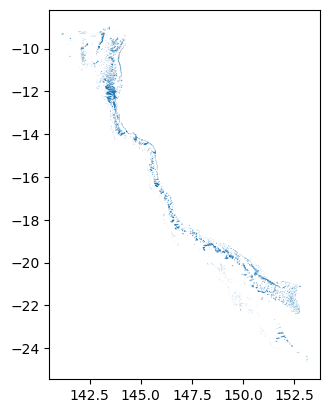

In [11]:
reefs.plot()

### Connect with the zarr file. 

In this case we are using NOAA CRW DHW data. It will work with any other zarr item that has the same structure.

In [12]:
## Connect with CRW DHW product
# Path to zarr files
zarr_path = "s3://gbr-dms-data-public/noaa-crw-chs-dhw/data.zarr"

# Connection to public S3 bucket - No credentials needed
fs = s3fs.S3FileSystem(anon=True)

# Loading zarr file
dhwAll = xr.open_dataset(s3fs.S3Map(zarr_path, s3=fs), engine="zarr")
dhwAll

<xarray.Dataset> Size: 166GB
Dimensions:              (time: 14372, lat: 900, lon: 1600)
Coordinates:
  * lat                  (lat) float32 4kB -5.025 -5.075 ... -49.92 -49.97
  * lon                  (lon) float32 6kB 100.0 100.1 100.1 ... 179.9 180.0
  * time                 (time) datetime64[ns] 115kB 1985-03-25T12:00:00 ... ...
Data variables:
    crs                  int16 2B ...
    degree_heating_week  (time, lat, lon) float32 83GB ...
    mask                 (time, lat, lon) float32 83GB ...
Attributes: (12/59)
    Conventions:                CF-1.6, ACDD-1.3
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    acknowledgement:            NOAA Coral Reef Watch Program
    cdm_data_type:              Grid
    comment:                    This is a product of the NOAA Coral Reef Watc...
    contributor_name:           NOAA Coral Reef Watch Program
    ...                         ...
    time_coverage_duration:     P1D
    time_coverage_end:          20240730T000000Z
    time_coverage_resolution:   P1D
    time_coverage_start:        20240729T000000Z
    title:                      NOAA Coral Reef Watch Daily Global 5km Satell...
    uuid:                       24c7f597-298c-4be6-a0c2-ad97b993f60f

For this example we will select the daily layers from the summer of 2023.

In [28]:

startDate = "2023-01-01"
endDate = "2023-04-30"
dhwSummer = dhwAll.sel(time=slice(startDate, endDate)).degree_heating_week
## clip to GBR region
dhwSummer = dhwSummer.sel(lat=slice(-7, -25), lon=slice(140, 155))
# plot the first layer
dhwSummer

<xarray.DataArray 'degree_heating_week' (time: 120, lat: 360, lon: 300)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 1kB -7.025 -7.075 -7.125 ... -24.88 -24.92 -24.98
  * lon      (lon) float32 1kB 140.0 140.1 140.1 140.2 ... 154.9 154.9 155.0
  * time     (time) datetime64[ns] 960B 2023-01-01T12:00:00 ... 2023-04-30T12...
Attributes:
    coverage_content_type:  physicalMeasurement
    grid_mapping:           crs
    long_name:              degree heating week
    standard_name:          N/A
    units:                  degree_Celsius_weeks
    valid_max:              10000
    valid_min:              0

We need to define the CRS and the variables that define the geographical extent

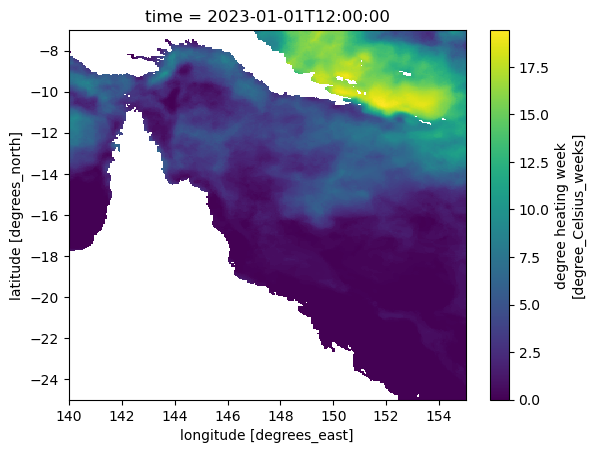

In [32]:
dhwSummer.rio.set_crs(4326, inplace=True)
dhwSummer.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dhwSummer[0,:,:].plot()

### Convert the vector (polygons) dataset to raster

The reef polygons need to be converted (rasterised) to a data array with the same shape as the raster dataset. We will use UNIQUE_ID (as an integer) as the value for the rasterised polygons.

In [30]:
# First clip the 
#DHW_clipped = dhw2024.rio.clip(data.geometry.values, data.crs, drop=True, all_touched=True)

## rasterise reef polygons using geocube
Reefraster = make_geocube(vector_data=reefs, measurements=["UNIQUE_ID"], like=dhwSummer)
Reefraster

<xarray.Dataset> Size: 869kB
Dimensions:      (y: 360, x: 300)
Coordinates:
  * y            (y) float64 3kB -7.025 -7.075 -7.125 ... -24.88 -24.93 -24.98
  * x            (x) float64 2kB 140.0 140.1 140.1 140.2 ... 154.9 154.9 155.0
    spatial_ref  int64 8B 0
Data variables:
    UNIQUE_ID    (y, x) float64 864kB nan nan nan nan nan ... nan nan nan nan

plot the rasterised reef polygons

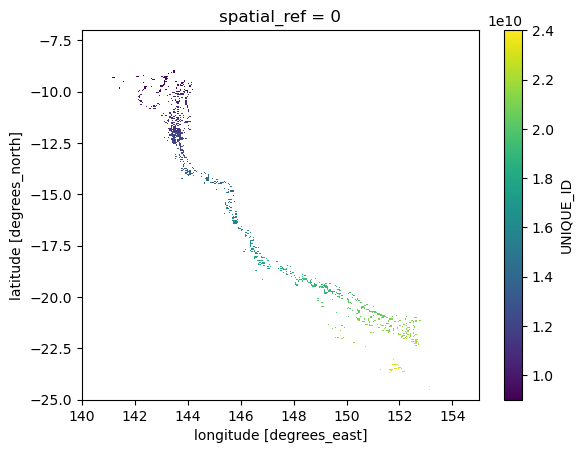

In [31]:
Reefraster.UNIQUE_ID.plot()

### Extract zonal statistics

This will return the zonal statistics for the first layer (time) in the raster dataset.

In [33]:

stats_df = stats(zones=Reefraster.UNIQUE_ID, values=dhwSummer[0,:,:])
stats_df

,zone,mean,max,min,sum,std,var,count
0,9.002109e+09,5.835,5.86,5.81,11.670000,0.025,0.000625,2.0
1,9.004104e+09,4.650,4.65,4.65,4.650000,0.000,0.000000,1.0
2,9.015109e+09,6.040,6.04,6.04,6.040000,0.000,0.000000,1.0
3,9.169109e+09,5.735,5.98,5.49,11.469999,0.245,0.060025,2.0
4,9.176109e+09,4.410,4.41,4.41,4.410000,0.000,0.000000,1.0
...,...,...,...,...,...,...,...,...
644,2.307110e+10,0.000,0.00,0.00,0.000000,0.000,0.000000,1.0
645,2.307210e+10,0.000,0.00,0.00,0.000000,0.000,0.000000,1.0
646,2.307710e+10,0.000,0.00,0.00,0.000000,0.000,0.000000,2.0
647,2.401010e+10,0.000,0.00,0.00,0.000000,0.000,0.000000,1.0


## Plot the results

Let's make an histogram of the DHW maximum values for each reef polygon. Note that the maximum is calculated over all pixels covering the reef polygon.

<Axes: ylabel='Frequency'>

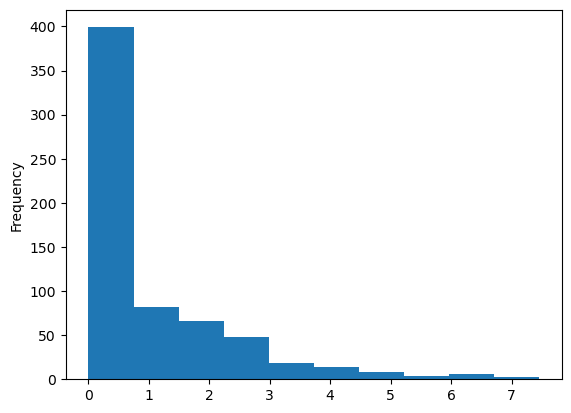

In [35]:
stats_df['max'].plot.hist()

## Multilayer raster
In this case, as zonal statistics are calculted for one layer only, we need to loop over all layers in the raster dataset.

In [36]:
## Get the number of layers
nlyr = dhwSummer.shape[0]
nlyr


120

Proceesing all layers may take some time. We add a variable `time` to the resulting stats table to identify the time of each layer.

In [53]:
%%time
## Create an empty df
statsAll = pd.DataFrame(columns=['zone', 'mean', 'max', 'min', 'sum', 'std', 'var', 'count', 'time'])
## loop over time layers
for i in range(nlyr):
    #print(dhwSummer.time[i].values)
    stats_df = stats(zones=Reefraster.UNIQUE_ID, values=dhwSummer[i,:,:].drop_vars('time'))
    stats_df['time'] = dhwSummer.time[i].values
    statsAll = pd.concat([statsAll, stats_df], ignore_index=True)

statsAll= statsAll.set_index('time')
statsAll

2023-01-01 12:00:00
2023-01-02 12:00:00


<timed exec>:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


2023-01-03 12:00:00
2023-01-04 12:00:00
2023-01-05 12:00:00
2023-01-06 12:00:00
2023-01-07 12:00:00
2023-01-08 12:00:00
2023-01-09 12:00:00
2023-01-10 12:00:00
2023-01-11 12:00:00
2023-01-12 12:00:00
2023-01-13 12:00:00
2023-01-14 12:00:00
2023-01-15 12:00:00
2023-01-16 12:00:00
2023-01-17 12:00:00
2023-01-18 12:00:00
2023-01-19 12:00:00
2023-01-20 12:00:00
2023-01-21 12:00:00
2023-01-22 12:00:00
2023-01-23 12:00:00
2023-01-24 12:00:00
2023-01-25 12:00:00
2023-01-26 12:00:00
2023-01-27 12:00:00
2023-01-28 12:00:00
2023-01-29 12:00:00
2023-01-30 12:00:00
2023-01-31 12:00:00
2023-02-01 12:00:00
2023-02-02 12:00:00
2023-02-03 12:00:00
2023-02-04 12:00:00
2023-02-05 12:00:00
2023-02-06 12:00:00
2023-02-07 12:00:00
2023-02-08 12:00:00
2023-02-09 12:00:00
2023-02-10 12:00:00
2023-02-11 12:00:00
2023-02-12 12:00:00
2023-02-13 12:00:00
2023-02-14 12:00:00
2023-02-15 12:00:00
2023-02-16 12:00:00
2023-02-17 12:00:00
2023-02-18 12:00:00
2023-02-19 12:00:00
2023-02-20 12:00:00
2023-02-21 12:00:00


,zone,mean,max,min,sum,std,var,count
time,,,,,,,,
2023-01-01 12:00:00,9.002109e+09,5.835,5.86,5.81,11.670000,0.025,0.000625,2.0
2023-01-01 12:00:00,9.004104e+09,4.650,4.65,4.65,4.650000,0.000,0.000000,1.0
2023-01-01 12:00:00,9.015109e+09,6.040,6.04,6.04,6.040000,0.000,0.000000,1.0
2023-01-01 12:00:00,9.169109e+09,5.735,5.98,5.49,11.469999,0.245,0.060025,2.0
2023-01-01 12:00:00,9.176109e+09,4.410,4.41,4.41,4.410000,0.000,0.000000,1.0
...,...,...,...,...,...,...,...,...
2023-04-30 12:00:00,2.307110e+10,0.300,0.30,0.30,0.300000,0.000,0.000000,1.0
2023-04-30 12:00:00,2.307210e+10,0.000,0.00,0.00,0.000000,0.000,0.000000,1.0
2023-04-30 12:00:00,2.307710e+10,0.535,0.60,0.47,1.070000,0.065,0.004225,2.0


Every row of the stats table represents the zonal statistics for each of the reefs in one layer (time) in the raster dataset. The following is a list of the reef's UNIQUE_ID

In [40]:
uniqueID = statsAll['zone'].unique()
print(uniqueID.astype(int))

[ 9002109100  9004104100  9015109101  9169109102  9176109101  9227104101
  9246104100  9249109102  9279104100  9281104100  9290104100  9291104100
  9299104108  9321104101  9343104100  9351104100  9353104100  9355104100
  9357104100  9358104100  9360104102  9376104100  9378104101  9379104100
  9394104100  9397104101  9399104101  9414104100  9415104101  9424104101
  9437104100  9440104100  9449104100  9450104100  9458104100  9468104100
  9480104100  9484104100  9487104100  9489104100  9492104101  9493104100
  9496104100  9503104101  9503104103  9511104100  9514104100  9523104100
  9527104100  9531104100  9541104100  9542104100  9551104100  9560104101
  9562104100  9563104100  9570104100  9609104100 10118109102 10120109105
 10138109117 10184104106 10201104100 10204104100 10214104100 10215104100
 10302104100 10305104100 10320100104 10325100104 10327100104 10332100104
 10335100104 10336100104 10345104101 10381100104 10386100104 10392100104
 10396100104 10398100104 10404100104 10411102104 10

## Plot the results

Let's plot a time series of the maximum DHW values for one specific reef id

<Axes: xlabel='time'>

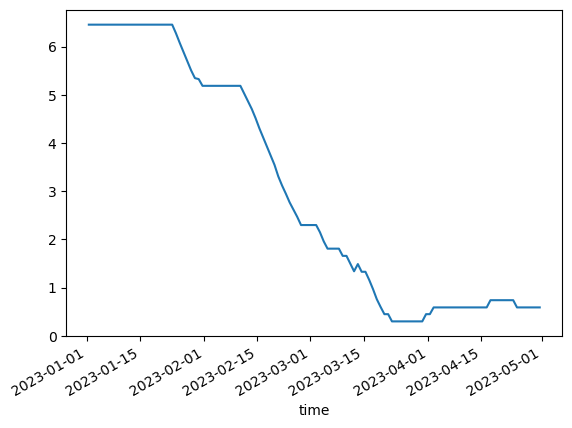

In [54]:
statsAll.loc[statsAll['zone'] == 9394104100]['max'].plot()

## END